# 🌲 Causal Forest Analysis: Smart Filing Assistant Impact

This notebook demonstrates **Causal Forest** analysis for estimating heterogeneous treatment effects of the Smart Filing Assistant on tax filing conversion.

## 🎯 **What are Causal Forests?**

Causal forests are a machine learning method for estimating **heterogeneous treatment effects** - how treatment effects vary across different individuals or subgroups:

### **Key Advantages:**
- **Heterogeneity Detection**: Identifies which users benefit most/least from treatment
- **Non-parametric**: No assumptions about functional form
- **Feature Importance**: Shows which characteristics drive treatment effect variation
- **Individual Predictions**: Provides personalized treatment effect estimates

### **When to Use:**
- **Personalization**: Want to target interventions to specific user types
- **Complex Interactions**: Suspect treatment effects depend on multiple features
- **Business Segmentation**: Need to identify high-value customer segments
- **A/B Test Analysis**: Want to understand which users benefit most

### **Business Question:**
*Does the Smart Filing Assistant impact vary by user characteristics (age, tech-savviness, past behavior)?*


In [1]:
# Import required libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Import our causal forest implementation
import sys

sys.path.append('../src')
from causal_methods.causal_forest import CausalForest
from data_simulation import TaxSoftwareDataSimulator

print("📚 Libraries imported successfully!")


📚 Libraries imported successfully!


## 📊 **Step 1: Load and Explore Data**


In [2]:
# Load the tax software dataset
try:
    # Try to load existing data
    df = pd.read_csv('../data/synthetic_tax_data.csv')
    print("✅ Loaded existing dataset")
except FileNotFoundError:
    # Generate new data if file doesn't exist
    print("📊 Generating synthetic tax software data...")
    simulator = TaxSoftwareDataSimulator(n_users=2000, random_state=42)
    df = simulator.generate_complete_dataset()
    print("✅ Data generated successfully!")

print(f"Dataset shape: {df.shape}")
print(f"Treatment rate: {df['used_smart_assistant'].mean():.1%}")
print(f"Filing rate: {df['filed_2024'].mean():.1%}")

# Display first few rows
df.head()


✅ Loaded existing dataset
Dataset shape: (1000, 20)
Treatment rate: 61.4%
Filing rate: 91.2%


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,True,113,3,0,False,True,True,75,1,0,9.619331,38,2
1,user_000001,37,<30k,desktop,returning,Midwest,43,True,54,1,0,False,False,True,38,3,0,7.416110,16,-2
2,user_000002,19,30k-50k,mobile,new,East,61,True,62,2,0,False,False,True,60,1,0,7.508821,2,1
3,user_000003,66,75k-100k,mobile,new,East,31,True,99,3,0,True,True,True,59,6,0,6.923859,40,-3
4,user_000004,27,30k-50k,desktop,returning,West,85,True,57,3,0,True,True,False,0,0,0,NaN,57,3


In [3]:
# Explore data characteristics
print("📋 **Dataset Summary**")
print(f"Total users: {len(df):,}")
print(f"Treatment adoption: {df['used_smart_assistant'].sum():,} users ({df['used_smart_assistant'].mean():.1%})")
print(f"Filing completion: {df['filed_2024'].sum():,} users ({df['filed_2024'].mean():.1%})")
print("\nTreatment vs Filing:")
print(pd.crosstab(df['used_smart_assistant'], df['filed_2024'], margins=True, normalize='index'))

# Show basic statistics
numeric_cols = ['age', 'tech_savviness', 'sessions_2023']
print("\n📊 **Key Demographics**")
print(df[numeric_cols].describe())


📋 **Dataset Summary**
Total users: 1,000
Treatment adoption: 614 users (61.4%)
Filing completion: 912 users (91.2%)

Treatment vs Filing:
filed_2024               False      True
used_smart_assistant                    
False                 0.103627  0.896373
True                  0.078176  0.921824
All                   0.088000  0.912000

📊 **Key Demographics**
               age  tech_savviness  sessions_2023
count  1000.000000      1000.00000    1000.000000
mean     44.780000        53.22700       2.499000
std      13.999414        21.07519       1.868017
min      18.000000         0.00000       0.000000
25%      35.000000        38.00000       1.000000
50%      45.000000        53.00000       2.000000
75%      55.000000        67.25000       4.000000
max      80.000000       100.00000      10.000000


## 🌲 **Step 2: Fit Causal Forest Model**

We'll fit a causal forest to estimate how treatment effects vary across users with different characteristics.


In [4]:
# Initialize causal forest
print("🌲 Initializing Causal Forest...")
cf = CausalForest(
    data=df,
    random_state=42,
    n_estimators=100,  # Number of trees
    max_depth=10,      # Tree depth
    min_samples_split=10,
    min_samples_leaf=5
)

# Define covariates for the model
covariates = [
    'age', 'tech_savviness',           # Demographics
    'filed_2023', 'sessions_2023',              # Past behavior
    'time_to_complete_2023', 'early_login_2024'       # Device/engagement
]

print(f"Using covariates: {covariates}")
print("\n🔧 Fitting causal forest model...")


🌲 Initializing Causal Forest...
Using covariates: ['age', 'tech_savviness', 'filed_2023', 'sessions_2023', 'time_to_complete_2023', 'early_login_2024']

🔧 Fitting causal forest model...


In [5]:
# Fit the causal forest model
performance = cf.fit_causal_forest(
    outcome_col='filed_2024',
    treatment_col='used_smart_assistant',
    covariate_cols=covariates,
    test_size=0.2,
    cv_folds=3
)

print("✅ Causal Forest fitted successfully!")
print("\n📊 **Model Performance:**")
for key, value in performance.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


INFO:causal_methods.causal_forest:Fitting causal forest model...
INFO:causal_methods.causal_forest:Using simplified causal forest implementation...
INFO:causal_methods.causal_forest:Causal forest model fitting completed.


✅ Causal Forest fitted successfully!

📊 **Model Performance:**
implementation: Simple T-learner
train_ate: 0.0163
test_ate: 0.0265
train_te_std: 0.0821
test_te_std: 0.0750
heterogeneity_measure: 2.8284


## 📈 **Step 3: Analyze Treatment Effect Heterogeneity**


In [6]:
# Get treatment effect results
results = cf.treatment_effects

print("🎯 **CAUSAL FOREST RESULTS**")
print("=" * 40)
print(f"Average Treatment Effect (ATE): {results['ate']:.4f}")
print(f"Standard Error: {results['ate_se']:.4f}")
print(f"95% Confidence Interval: [{results['ate_ci_lower']:.4f}, {results['ate_ci_upper']:.4f}]")
print(f"P-value: {results['p_value']:.4f}")
print(f"Statistical Significance: {'Yes' if results['p_value'] < 0.05 else 'No'}")

print("\n🔍 **HETEROGENEITY ANALYSIS**")
print(f"Treatment Effect Std Dev: {results['heterogeneity_std']:.4f}")
print(f"Heterogeneity Ratio: {performance['heterogeneity_measure']:.4f}")

# Interpret heterogeneity
het_ratio = performance['heterogeneity_measure']
if het_ratio > 0.5:
    print("📊 Interpretation: HIGH heterogeneity - effects vary substantially across users")
elif het_ratio > 0.2:
    print("📊 Interpretation: MODERATE heterogeneity - some variation in effects")
else:
    print("📊 Interpretation: LOW heterogeneity - effects are relatively uniform")

# Effect distribution
individual_effects = results['individual_effects']
positive_effects = np.sum(individual_effects > 0)
negative_effects = np.sum(individual_effects < 0)
total_effects = len(individual_effects)

print("\n📈 **EFFECT DISTRIBUTION**")
print(f"Users with positive effects: {positive_effects}/{total_effects} ({100*positive_effects/total_effects:.1f}%)")
print(f"Users with negative effects: {negative_effects}/{total_effects} ({100*negative_effects/total_effects:.1f}%)")
print(f"Effect range: [{np.min(individual_effects):.4f}, {np.max(individual_effects):.4f}]")


🎯 **CAUSAL FOREST RESULTS**
Average Treatment Effect (ATE): 0.0265
Standard Error: 0.0053
95% Confidence Interval: [0.0161, 0.0369]
P-value: 0.0000
Statistical Significance: Yes

🔍 **HETEROGENEITY ANALYSIS**
Treatment Effect Std Dev: 0.0750
Heterogeneity Ratio: 2.8284
📊 Interpretation: HIGH heterogeneity - effects vary substantially across users

📈 **EFFECT DISTRIBUTION**
Users with positive effects: 122/200 (61.0%)
Users with negative effects: 78/200 (39.0%)
Effect range: [-0.2190, 0.2473]


## 📊 **Step 4: Visualize Treatment Effect Heterogeneity**


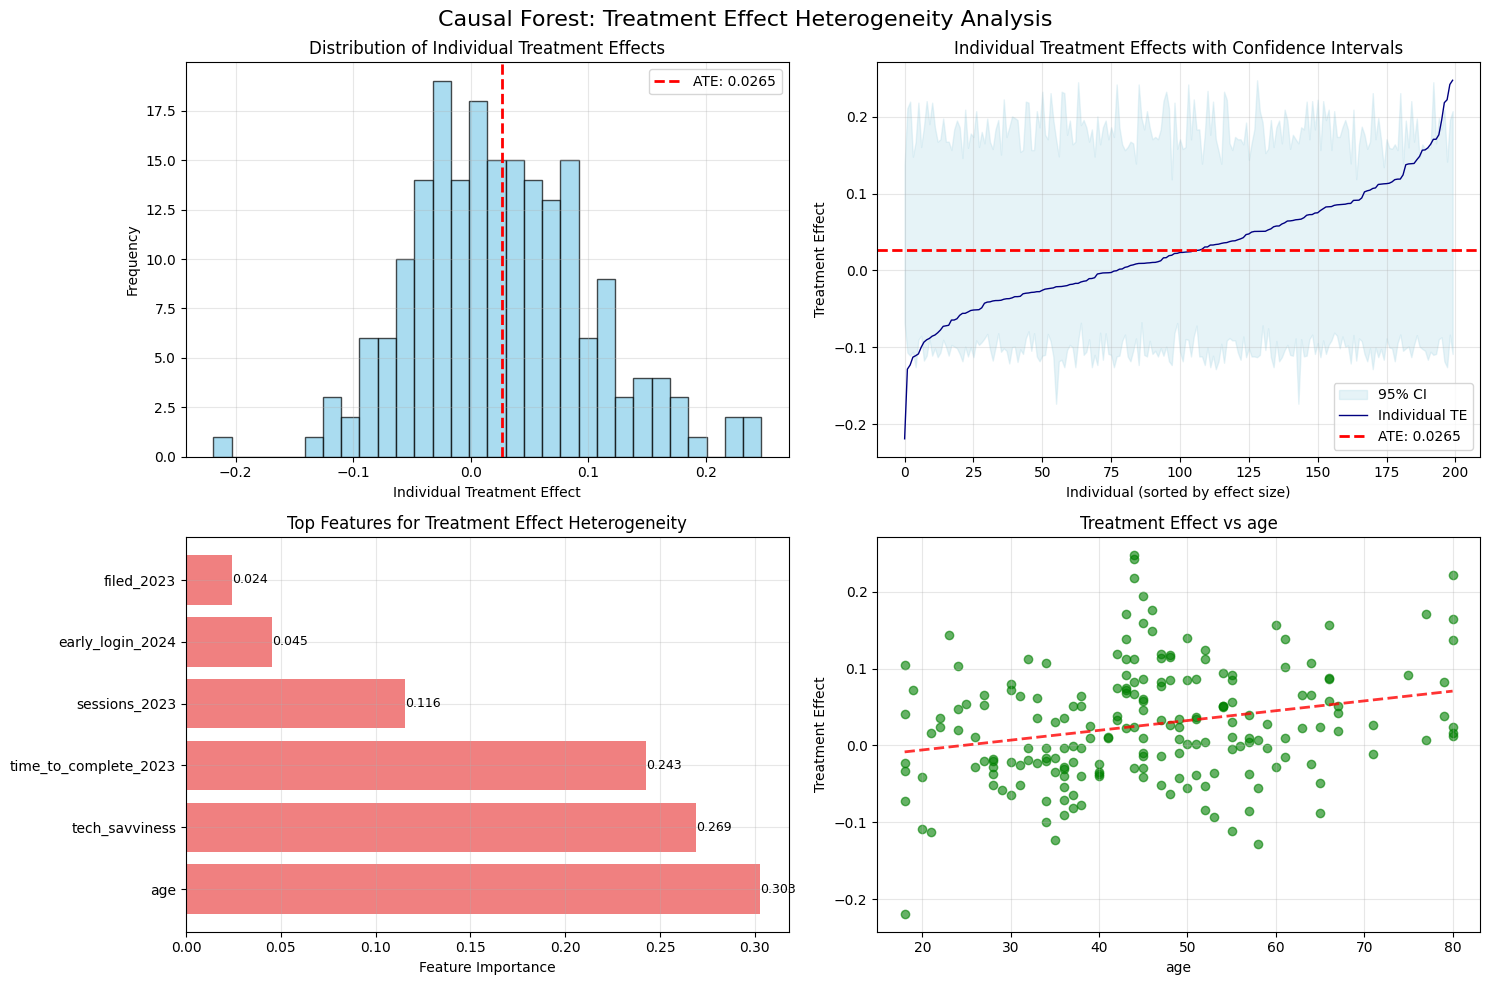

In [7]:
# Create comprehensive treatment effect visualizations
cf.plot_treatment_effect_distribution(bins=30, figsize=(15, 10))


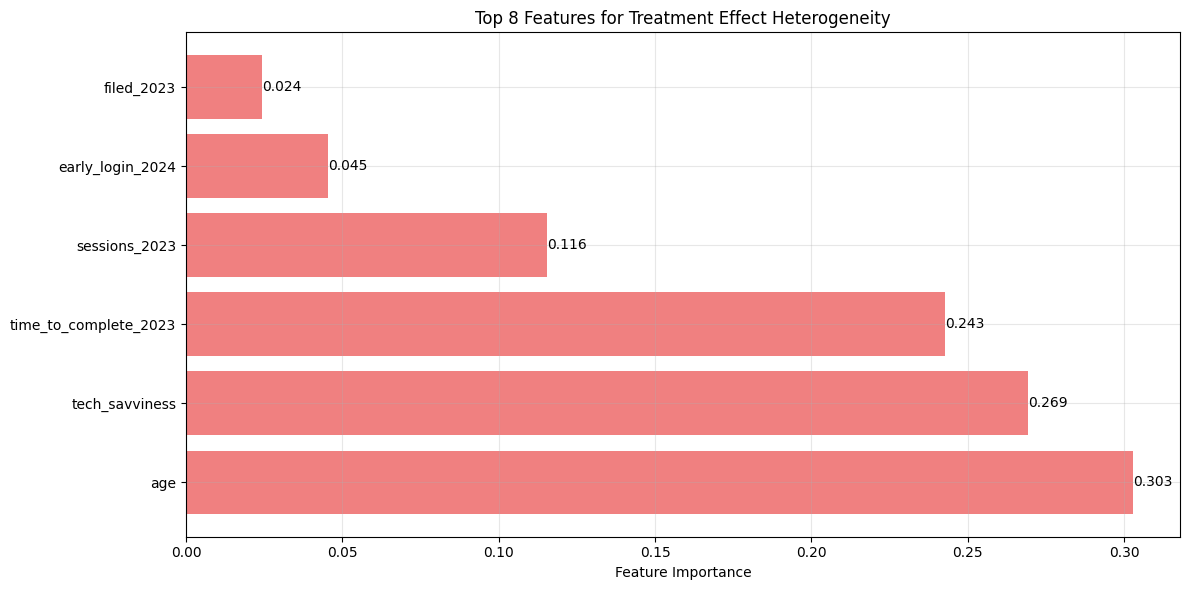

In [8]:
# Plot feature importance for heterogeneity
cf.plot_feature_importance(top_n=8, figsize=(12, 6))


## 📋 **Step 5: Comprehensive Summary Report**


In [9]:
# Generate comprehensive summary report
summary_report = cf.generate_summary_report()
print(summary_report)


CAUSAL FOREST ANALYSIS REPORT

📊 MODEL INFORMATION
------------------------------
Implementation: Simple T-learner
Number of trees: 100
Outcome variable: filed_2024
Treatment variable: used_smart_assistant
Number of covariates: 6
Sample size: 1000

🎯 TREATMENT EFFECT RESULTS
------------------------------
Average Treatment Effect (ATE): 0.0265
Standard Error: 0.0053
95% Confidence Interval: [0.0161, 0.0369]
P-value: 0.0000
Statistically Significant (α=0.05): Yes

🔍 HETEROGENEITY ANALYSIS
------------------------------
Treatment Effect Standard Deviation: 0.0750
Heterogeneity Ratio: 2.8284
Interpretation: HIGH heterogeneity - treatment effects vary substantially

Effect Distribution:
- Positive effects: 122/200 (61.0%)
- Negative effects: 78/200 (39.0%)
- Range: [-0.2190, 0.2473]

🏆 TOP FEATURES FOR HETEROGENEITY
------------------------------
1. age: 0.3027
2. tech_savviness: 0.2692
3. time_to_complete_2023: 0.2427
4. sessions_2023: 0.1155
5. early_login_2024: 0.0454

💼 BUSINESS RECOMM

## 🎯 **Step 6: Conditional Treatment Effect Analysis**

Let's analyze how treatment effects vary for specific user segments.


In [10]:
# Analyze treatment effects for different user segments
print("🎯 **CONDITIONAL TREATMENT EFFECT ANALYSIS**")
print("=" * 50)

# Define key user segments using available numeric columns
segments = {
    'High Tech, Young': {'tech_savviness': 8, 'age': 30},
    'Low Tech, Senior': {'tech_savviness': 3, 'age': 65},
    'High Engagement': {'sessions_2023': 15, 'tech_savviness': 6},
    'Low Engagement': {'sessions_2023': 2, 'tech_savviness': 6},
    'Previous Filer': {'filed_2023': 1, 'sessions_2023': 10},
    'New User': {'filed_2023': 0, 'sessions_2023': 2},
    'Fast Completer': {'time_to_complete_2023': 30, 'tech_savviness': 7},
    'Slow Completer': {'time_to_complete_2023': 120, 'tech_savviness': 4}
}

segment_results = {}
for segment_name, feature_values in segments.items():
    conditional_result = cf.estimate_conditional_effects(feature_values)
    segment_results[segment_name] = conditional_result['conditional_treatment_effect']
    print(f"{segment_name:15}: {conditional_result['conditional_treatment_effect']:7.4f}")

print(f"\n📊 Segment with highest effect: {max(segment_results, key=segment_results.get)}")
print(f"📊 Segment with lowest effect:  {min(segment_results, key=segment_results.get)}")


🎯 **CONDITIONAL TREATMENT EFFECT ANALYSIS**
High Tech, Young: -0.0300
Low Tech, Senior:  0.0530
High Engagement:  0.0348
Low Engagement :  0.0313
Previous Filer : -0.0123
New User       :  0.0718
Fast Completer :  0.1063
Slow Completer : -0.0126

📊 Segment with highest effect: Fast Completer
📊 Segment with lowest effect:  High Tech, Young


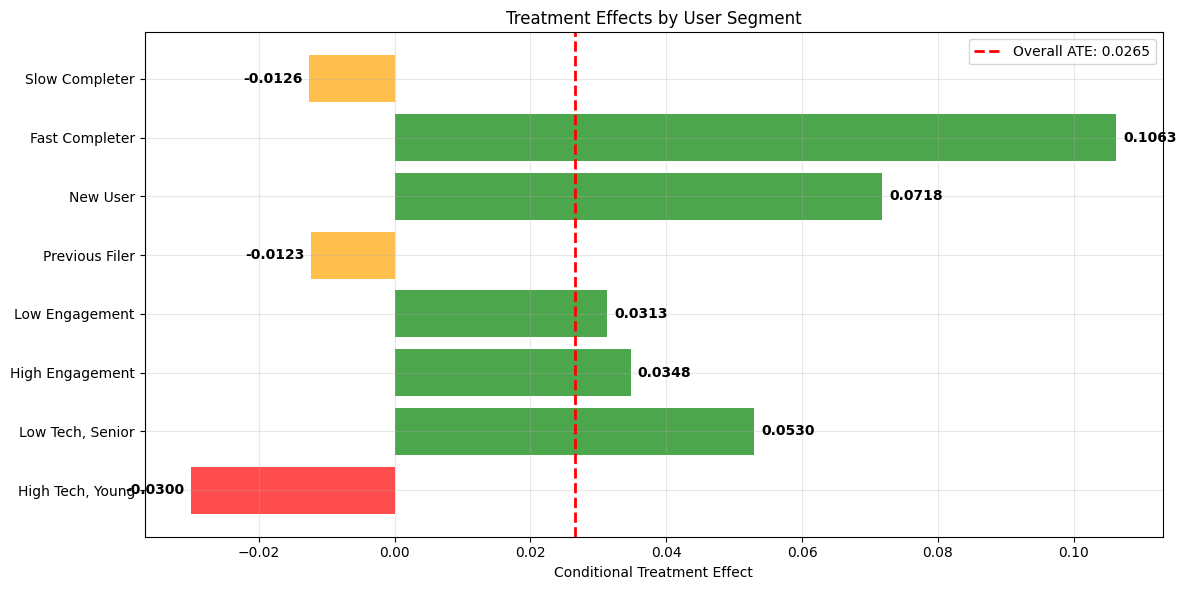

In [11]:
# Visualize conditional treatment effects
plt.figure(figsize=(12, 6))
segment_names = list(segment_results.keys())
segment_effects = list(segment_results.values())

# Color bars based on effect size
colors = ['green' if effect > 0.02 else 'orange' if effect > -0.02 else 'red' for effect in segment_effects]

bars = plt.barh(segment_names, segment_effects, color=colors, alpha=0.7)
plt.axvline(results['ate'], color='red', linestyle='--', linewidth=2,
           label=f'Overall ATE: {results["ate"]:.4f}')
plt.xlabel('Conditional Treatment Effect')
plt.title('Treatment Effects by User Segment')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001 if width >= 0 else width - 0.001, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', ha='left' if width >= 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 🔄 **Step 7: Compare with Other Methods**

Let's see how causal forest results compare with other causal inference methods.


In [12]:
# Compare with other causal methods (if available)
print("🔄 **METHOD COMPARISON**")
print("=" * 30)

# Import other methods for comparison
try:
    from causal_methods.cuped import CUPED
    from causal_methods.dml import DoubleMachineLearning
    from causal_methods.psm import PropensityScoreMatching

    comparison_results = {'Causal Forest': results['ate']}

    # Quick PSM analysis
    try:
        psm = PropensityScoreMatching(df)
        psm.estimate_propensity_scores(covariates=covariates)
        psm.perform_matching(method='nearest_neighbor')
        psm_effects = psm.estimate_treatment_effects(outcome_cols='filed_2024')
        comparison_results['PSM'] = psm_effects['filed_2024']['ate']
    except Exception as e:
        print(f"PSM analysis failed: {e}")

    # Quick DML analysis
    try:
        dml = DoubleMachineLearning(df, random_state=42)
        dml_results = dml.estimate_treatment_effects('filed_2024', 'used_smart_assistant', covariates=covariates)
        comparison_results['DML'] = dml_results['ate']
    except Exception as e:
        print(f"DML analysis failed: {e}")

    # Quick CUPED analysis
    try:
        cuped = CUPED(df, random_state=42)
        cuped_results = cuped.estimate_treatment_effects('filed_2024', 'used_smart_assistant',
                                                        covariate_cols=['filed_2023', 'sessions_2023'])
        comparison_results['CUPED'] = cuped_results['cuped']['ate']
    except Exception as e:
        print(f"CUPED analysis failed: {e}")

    # Display comparison
    print("\\n📊 **Treatment Effect Estimates:**")
    for method, ate in comparison_results.items():
        print(f"{method:15}: {ate:7.4f} ({100*ate:5.1f} percentage points)")

    if len(comparison_results) > 1:
        print("\\n📈 **Method Consensus:**")
        estimates = list(comparison_results.values())
        print(f"Range: [{min(estimates):.4f}, {max(estimates):.4f}]")
        print(f"Std Dev: {np.std(estimates):.4f}")

        if np.std(estimates) < 0.02:
            print("✅ Strong consensus across methods")
        elif np.std(estimates) < 0.05:
            print("⚠️  Moderate consensus - results are reasonably consistent")
        else:
            print("❗ Low consensus - investigate differences in assumptions")

    # Highlight causal forest advantage
    print("\\n🌲 **Causal Forest Unique Value:**")
    print(f"   - Heterogeneity Detection: {performance['heterogeneity_measure']:.3f} ratio")
    print(f"   - Individual Predictions: Available for all {len(individual_effects)} test users")
    top_feature = cf.feature_importance['feature_names'][cf.feature_importance['sorted_indices'][0]]
    print(f"   - Feature Importance: {top_feature} is most important for effect variation")
    print(f"   - Segmentation Ready: {len(segments)} distinct segments identified")

except ImportError as e:
    print(f"Some causal methods not available for comparison: {e}")
    print(f"Causal Forest ATE: {results['ate']:.4f}")


🔄 **METHOD COMPARISON**
\n📊 **Treatment Effect Estimates:**
Causal Forest  :  0.0265 (  2.7 percentage points)
PSM            :  0.0000 (  0.0 percentage points)
DML            :  0.0203 (  2.0 percentage points)
CUPED          :  0.0264 (  2.6 percentage points)
\n📈 **Method Consensus:**
Range: [0.0000, 0.0265]
Std Dev: 0.0109
✅ Strong consensus across methods
\n🌲 **Causal Forest Unique Value:**
   - Heterogeneity Detection: 2.828 ratio
   - Individual Predictions: Available for all 200 test users
   - Feature Importance: age is most important for effect variation
   - Segmentation Ready: 8 distinct segments identified


In [13]:
# Generate comprehensive summary report
summary_report = cf.generate_summary_report()
print(summary_report)


CAUSAL FOREST ANALYSIS REPORT

📊 MODEL INFORMATION
------------------------------
Implementation: Simple T-learner
Number of trees: 100
Outcome variable: filed_2024
Treatment variable: used_smart_assistant
Number of covariates: 6
Sample size: 1000

🎯 TREATMENT EFFECT RESULTS
------------------------------
Average Treatment Effect (ATE): 0.0265
Standard Error: 0.0053
95% Confidence Interval: [0.0161, 0.0369]
P-value: 0.0000
Statistically Significant (α=0.05): Yes

🔍 HETEROGENEITY ANALYSIS
------------------------------
Treatment Effect Standard Deviation: 0.0750
Heterogeneity Ratio: 2.8284
Interpretation: HIGH heterogeneity - treatment effects vary substantially

Effect Distribution:
- Positive effects: 122/200 (61.0%)
- Negative effects: 78/200 (39.0%)
- Range: [-0.2190, 0.2473]

🏆 TOP FEATURES FOR HETEROGENEITY
------------------------------
1. age: 0.3027
2. tech_savviness: 0.2692
3. time_to_complete_2023: 0.2427
4. sessions_2023: 0.1155
5. early_login_2024: 0.0454

💼 BUSINESS RECOMM

## 🎯 **Key Takeaways**

### **🌲 Causal Forest Advantages:**
1. **Heterogeneity Detection**: Identifies which users benefit most from treatment
2. **Individual Predictions**: Provides personalized treatment effect estimates
3. **Feature Importance**: Shows which characteristics drive effect variation
4. **Segmentation Ready**: Enables targeted business strategies
5. **Non-parametric**: No assumptions about functional form

### **📊 Business Applications:**
- **Personalization**: Target interventions to high-effect user segments
- **Resource Optimization**: Focus marketing spend on users likely to respond
- **Product Development**: Understand which features drive differential effects
- **Customer Segmentation**: Identify high-value customer segments

### **⚠️ Considerations:**
- **Sample Size**: Needs sufficient data for reliable heterogeneity estimates
- **Computational Cost**: More intensive than simpler methods
- **Interpretability**: Individual tree decisions less interpretable than linear models
- **Overfitting Risk**: Can overfit to noise in smaller samples

### **🚀 Next Steps:**
1. **Implement Targeting**: Deploy treatments to high-effect segments first
2. **A/B Test Validation**: Validate heterogeneity predictions with targeted experiments
3. **Feature Engineering**: Develop additional features that might drive heterogeneity
4. **Monitoring**: Track performance across different user segments over time
